In [1]:
import pickle as pkl
data = pkl.load(open('favorited_dict.p', 'rb'))
max_item, max_user = pkl.load(open('useful_stats.p', 'rb'))
visual_data = pkl.load(open('id_feature_dict_davis.p', 'rb'))

In [11]:
from tqdm import tqdm_notebook as tqdm
import numpy as np

In [58]:
removed_items = set()
for key in range(max_item):
    if key not in visual_data:
        removed_items.add(key)

In [46]:
users_to_remove = []
for user in data:
    images = np.unique(data[user]).tolist()
    images = [image for image in images if image in visual_data]
    if not images: users_to_remove.append(user)
    else: data[user] = images

for user in users_to_remove:
    data.pop(user)

In [47]:
def create_validation(data):
    valid = {}
    for key in data:
        rated_items = data[key]
        if len(rated_items) > 1:
            valid[key] = np.random.choice(rated_items)
        else:
            valid[key] = None
    return valid
        

In [48]:
valid = create_validation(data)

In [49]:
def sample_triple(data, valid, nSamples=1):
    samples = np.zeros((nSamples, 3), dtype=int)
    keys = list(data.keys())
    users = np.random.choice(keys, nSamples) 
    samples[:, 0] = users
    
    for i, user in enumerate(tqdm(users)):
        rated_items = data[user]
        if not rated_items: import pdb; pdb.set_trace()
        valid_item = valid[user]
        unrated_item = np.random.choice(max_item)
        while unrated_item in rated_items or unrated_item in removed_items or unrated_item == valid_item:
            unrated_item = np.random.choice(max_item)
            
        rated_item = np.random.choice(rated_items)
        while rated_item == valid_item:
            rated_item = np.random.choice(rated_items)

        samples[i, 1] = rated_item
        samples[i, 2] = unrated_item
            
    return samples


In [281]:
import math

def sigmoid(x):
    try:
        if type(x) in (int, float, np.float64):
            return 1 / (1 + math.exp(-x))
        else:
            if len(x) == 1:
                x = np.squeeze(x)
                return 1 / (1 + math.exp(-x))
            else:
                return 1 / (1 + np.exp(-x))
    except OverflowError:
        return 0

In [411]:
#hyperparameters
k=10
n=10
lr = 0.0001 # * 0.01
lam_u = .1
lam_bias = .1
lam_rated = .1
lam_unrated = .1
lam_vf = 1
lam_E = 1
lam_vu = 1

In [412]:
item_biases = np.random.normal(size=max_item)
latent_items = np.random.normal(size=(max_item, k), scale=0.1)
latent_users = np.random.normal(size=(max_user, k), scale=0.1)
visual_users = np.random.normal(size=(max_user, n), scale=0.1)
E = np.random.normal(size=(4096, n))
visual_bias = np.random.normal(size=(4096))

phi1 = 1
phi2 = 1
phi3 = 1
phi4 = 1

Note that all of the above values are regularized pretty good. The mean value is quite small. But the max visual_user is actually pretty big, so maybe it can use more regularization.

In [363]:
def BR_opt(rated_item_bias, unrated_item_bias, latent_user, latent_rated_item, 
           latent_unrated_item, E, vf_difference, visual_user, visual_bias, phi1, phi2, phi3, phi4):
        

    bias_difference = rated_item_bias - unrated_item_bias
    
    if latent_user.ndim == 1:
        latent_difference = np.dot(latent_rated_item - latent_unrated_item, latent_user)
    else:
        latent_difference = np.einsum('ij,ji->i', latent_rated_item - latent_unrated_item, 
                                  np.transpose(latent_user)) 
        
    vf_encoded = np.dot(np.transpose(E), vf_difference)
    visual_difference = np.dot(vf_encoded, visual_user)
    visual_bias_difference = np.dot(vf_difference, visual_bias)
    '''else:
        vf_encoded = np.dot(vf_difference, E)
        visual_difference = np.einsum('ij,ji->i', vf_encoded, np.transpose(visual_user))
        import pdb; pdb.set_trace()
        visual_bias_difference = np.dot(vf_difference, visual_bias[:,None])'''
    
    return (phi1*bias_difference + phi2*latent_difference + phi3*visual_difference + phi4*visual_bias_difference)

In [364]:
def create_valid_dataset(data, valid, nItems=10): #nItems is the number of items not in train/ valid 
    
    valid_list = list(valid.items())
    valid_users = [x[0] for x in valid_list if x[1] is not None]
    valid_items = [x[1] for x in valid_list if x[1] is not None]
    valid_users = np.repeat(valid_users, nItems)
    valid_items = np.repeat(valid_items, nItems)
    
    samples = np.zeros((len(valid_users), 3), dtype=int)
    samples[:, 0] = valid_users
    samples[:, 1] = valid_items
    
    for i, user in enumerate(valid_users):
        rated_items = data[user]
        valid_item = valid[user]
        unrated_item = np.random.choice(max_item)
        while unrated_item in rated_items or unrated_item in removed_items or unrated_item == valid_item:
            unrated_item = np.random.choice(max_item)
            
        samples[i, 2] = unrated_item
        
    return samples



In [365]:
def AUC(data, valid, item_biases, latent_items, latent_users, visual_users, E, visual_bias, phi1, phi2, phi3, phi4):

    samples = create_valid_dataset(data, valid, 5)

    auc = 0.0
    for user, rated_item, unrated_item in tqdm(samples):

        # Extract out the relevant variables
        rated_item_bias = item_biases[rated_item]
        unrated_item_bias = item_biases[unrated_item]
        latent_user = latent_users[user]
        latent_rated_item = latent_items[rated_item]
        latent_unrated_item = latent_items[unrated_item]

        visual_user = visual_users[user]
        rated_vf = visual_data[rated_item]
        unrated_vf = visual_data[unrated_item]
        vf_difference = rated_vf-unrated_vf
        # Determine the output, i.e. x_uij 
        br_opt = BR_opt(rated_item_bias, unrated_item_bias, latent_user, latent_rated_item, latent_unrated_item,
                        E, vf_difference, visual_user, visual_bias, phi1, phi2, phi3, phi4)

        auc += (br_opt > 0)
    return auc/len(samples)

In [416]:
aucs = []

In [417]:
samples = sample_triple(data, valid, 1000000)
count = 0
for user, rated_item, unrated_item in tqdm(samples):
    
    # Extract out the relevant variables
    rated_item_bias = item_biases[rated_item]
    unrated_item_bias = item_biases[unrated_item]
    latent_user = latent_users[user]
    latent_rated_item = latent_items[rated_item]
    latent_unrated_item = latent_items[unrated_item]
    
    visual_user = visual_users[user]
    rated_vf = visual_data[rated_item]
    unrated_vf = visual_data[unrated_item]
    vf_difference = rated_vf-unrated_vf
    # Determine the output, i.e. x_uij 
    br_opt = BR_opt(rated_item_bias, unrated_item_bias, latent_user, latent_rated_item, latent_unrated_item,
                    E, vf_difference, visual_user, visual_bias, phi1, phi2, phi3, phi4)
    
    output = sigmoid(-br_opt)

    # Perform gradient updates
    item_biases[rated_item] = (1-lr*lam_bias) * rated_item_bias + phi1 * lr * output
    item_biases[unrated_item] = (1-lr*lam_bias) * unrated_item_bias - phi1* lr * output
    
    latent_items[rated_item] = (1-lr*lam_rated) * latent_rated_item + phi2* lr * output * latent_user
    latent_items[unrated_item] = (1-lr*lam_unrated) * latent_unrated_item - phi2 * lr * output * latent_user
    latent_users[user] = (1-lr*lam_unrated) * latent_user \
                        + phi2 * lr * output * (latent_rated_item-latent_unrated_item)

    E = (1-lr*lam_E) * E + phi3* lr* output * (np.dot((vf_difference)[:,None],visual_user[None,:]))
    visual_users[user] = (1-lr*lam_vu) * visual_user + phi3* lr * output * np.dot(np.transpose(E), vf_difference)
    visual_bias = (1-lr*lam_vf)*visual_bias + phi4*lr * output * (vf_difference)
    
    phi1 = phi1 + lr * output * (rated_item_bias-unrated_item_bias)
    
    phi2 = phi2 + lr * output * np.dot(latent_rated_item-latent_unrated_item, latent_user)
    
    
    vf_encoded = np.dot(np.transpose(E), vf_difference)
    visual_difference = np.dot(vf_encoded, visual_user)
    visual_bias_difference = np.dot(vf_difference, visual_bias)
    
    phi3 = phi3 + lr * output * visual_difference 
    
    phi4 = phi4 + lr * output * visual_bias_difference
    
    count += 1

    if count % 250000 is 0:
        aucs.append(AUC(data, valid, item_biases, latent_items, latent_users, visual_users, E, visual_bias, phi1, phi2, phi3, phi4))

249749/|/ 25%|| 249749/1000000 [01:56<05:48, 2152.84it/s]

499815/|/ 50%|| 499815/1000000 [04:47<04:47, 1739.91it/s]

749748/|/ 75%|| 749748/1000000 [07:39<02:33, 1631.17it/s]

999880/|/100%|| 999880/1000000 [10:33<00:00, 1578.20it/s]


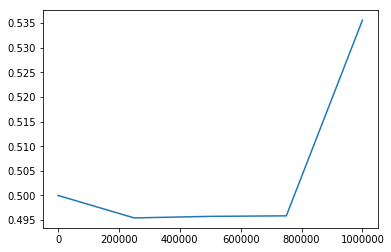

In [418]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.array(range(len(aucs)+1))*250000, [0.5]+aucs)


AUC(data, valid, item_biases, latent_items, latent_users, visual_users, E, visual_bias)